In [61]:
import numpy as np
import matplotlib.pyplot as plt
from QAM_EncoderDecoder import * 
import scipy.signal
%matplotlib inline

In [2]:
class OFDM:
    pass
ofdm = OFDM()
ofdm.K = 1024                      # Number of OFDM subcarriers
ofdm.Kon = 600                     # Number of switched-on subcarriers
ofdm.CP = 128                      # Number of samples in the CP
ofdm.ofdmSymbolsPerFrame = 5       # N, number of payload symbols in each frame
ofdm.L = ofdm.K//2                 # Parameter L, denotes the length of one repeated part of the preamble

In [3]:
def random_qam(ofdm):
    qam = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
    return np.random.choice(qam, size=(ofdm.Kon), replace=True)

In [4]:
def ofdm_modulate(ofdm, qam):
    assert (len(qam) == ofdm.Kon)
    fd_data = np.zeros(ofdm.K, dtype=complex)
    off = (ofdm.K - ofdm.Kon)//2
    fd_data[off:(off+len(qam))] = qam  # modulate in the center of the frequency
    fd_data = np.fft.fftshift(fd_data)
    symbol = np.fft.ifft(fd_data) * np.sqrt(ofdm.K)
    return np.hstack([symbol[-ofdm.CP:], symbol])

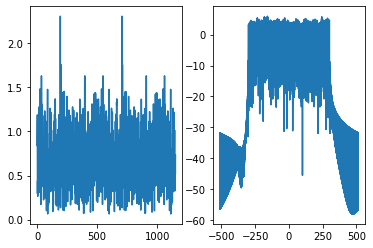

In [5]:
qam_preamble = np.sqrt(2)*random_qam(ofdm)
qam_preamble[::2] = 0   # delete every second data to make the preamble 2-periodic

preamble = ofdm_modulate(ofdm, qam_preamble)

plt.subplot(121)
plt.plot(abs(preamble))

plt.subplot(122)
f = np.linspace(-ofdm.K/2, ofdm.K/2, 4*len(preamble), endpoint=False)
plt.plot(f, 20*np.log10(abs(np.fft.fftshift(np.fft.fft(preamble, 4*len(preamble))/np.sqrt(len(preamble))))))

1. Create random preamble

In [23]:
N = 1024
prefix_no = 300
random_array = np.random.randint(0,100, int(50))
random_array[::2] = 0 
bin_strings=''
for byte in random_array:
    binary_string = '{0:08b}'.format(byte)
    bin_strings+=binary_string
symbols = encode_bitstr2symbols(bin_strings)
preamble = symbol_to_OFDMframes(symbols,N,prefix_no)

preamble = np.array(preamble)
print(preamble.shape)

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
about to do symbol_to_OFDMframes encoding
symbol_to_OFDMframes encoding finished
(1, 1324)


In [24]:
preamble = preamble[0] * 2 *np.sqrt(2)

Text(0.5, 1.0, 'Preamble in frequency')

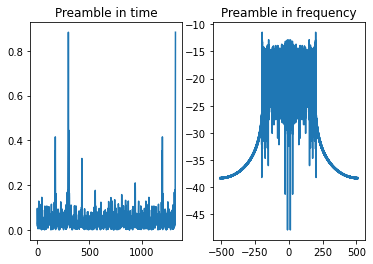

In [25]:
plt.subplot(121)
plt.plot(np.abs(preamble))
plt.title('Preamble in time')
plt.subplot(122)
f = np.linspace(-ofdm.K/2, ofdm.K/2, 4*len(preamble), endpoint=False)
plt.plot(f, 20*np.log10(np.abs(np.fft.fftshift(np.fft.fft(preamble, 4*len(preamble))/np.sqrt(len(preamble))))))
plt.title('Preamble in frequency')

2. Create the OFDM frame

In [28]:
random_symbol = np.random.randint(0,100, int(100))

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
400
about to do symbol_to_OFDMframes encoding
symbol_to_OFDMframes encoding finished
1324
C:\Users\H1937\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


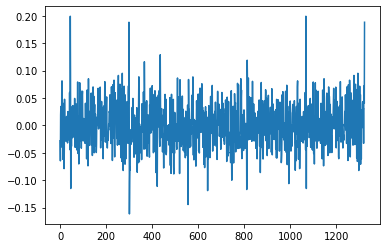

In [48]:
bin_strings=''
for byte in random_symbol:
    binary_string = '{0:08b}'.format(byte)
    bin_strings+=binary_string
bin_strings
symbols = encode_bitstr2symbols(bin_strings)
print(len(symbols))
frame = symbol_to_OFDMframes(symbols, N, prefix_no)[0] # original shape is (1, 1056)
#frame = np.fft.ifft(symbols)
# Adding cyclic prefix
#cyclic_prefix = frame[len(symbols)-prefix_no:len(symbols)]
        
#frame = np.append(cyclic_prefix, frame, axis=0)       

#frame = np.real(frame)* 5 # already has 0j part so make it real type
print(len(frame))
plt.plot(frame)

In [49]:
transmit = np.hstack([preamble, frame])

In [50]:
transmit.shape

(2648,)

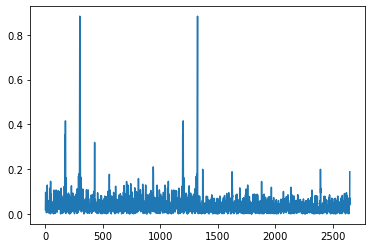

In [51]:
plt.plot(np.abs(transmit))

3. Run over a simulated channel: 

C:\Users\H1937\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


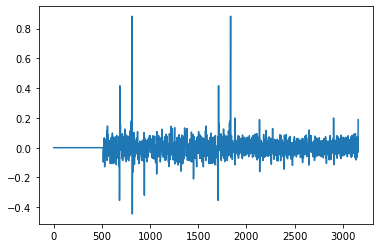

In [52]:
sto = N//2
channel = [0.5, 0.25, 0, 0.25]
#channel_op = np.convolve(channel, transmit)
channel_op = transmit
# Pad zeros
channel_op = np.hstack([np.zeros(sto), channel_op])
plt.plot(channel_op)

4. Calculating P(d)

In [53]:
sto + N

1536

In [54]:
channel_op.shape

(3160,)

In [55]:
# Method 1 to calculate P(d)
d_set = np.arange(0, sto + N)
P1 = np.zeros(len(d_set), dtype=complex)
for i, d in enumerate(d_set):
    P1[i] = sum(channel_op[d+m].conj()*channel_op[d+m+N//2] for m in range(N//2)) 

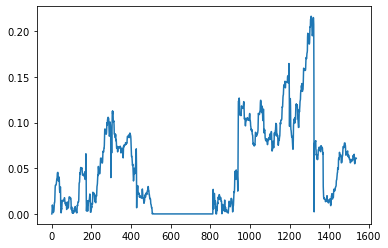

In [56]:
plt.plot(d_set, abs(P1))

The horizontal part is the cyclic prefix, here of length 300, starts from about 512, which is the delay of the channel and that is pretty accurate

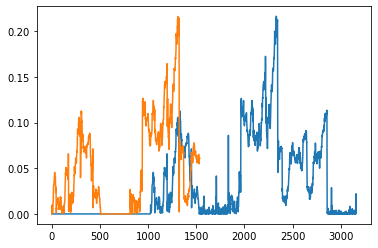

In [67]:
def calcP_method3(r):
    L = N//2
    b_P = np.zeros(L)
    b_P[0] = 1; b_P[L-1] = -1;
    a_P = (1, -1)
    
    # Implements r[d-L] * r[d], assuming r[d<0] = 0
    v_bar = np.hstack([np.zeros(L), r[L:].conj() * r[:-L]]) 
    P_bar = scipy.signal.lfilter(b_P, a_P, v_bar)
    return P_bar

P_bar = calcP_method3(channel_op)
plt.plot(abs(P_bar), label='$\\bar{P}(d)$')
plt.plot(abs(P1), label='$P(d)$')

2L filter Delay which is 1024 delay

5. calculate R

In [62]:
def calcR_method1(r, d_set):
    # calculation based on the iterative method
    R = np.zeros(len(d_set))
    for i, d in enumerate(d_set):
        R[i] = sum(abs(r[d+m+N//2])**2 for m in range(N//2))
    return R

def calcR_method2(r, d_set, R0):
    # calculation based on non-causal recursive expression
    R = np.zeros(len(d_set))
    R[0] = R0
    for d in d_set[:-1]:
        R[d+1] = R[d] + abs(r[d+2*N//2])**2-abs(r[d+N//2])**2
    return R

def calcR_method3(r):
    # calculation based on IIR filter expression
    b = np.zeros(N//2); b[0] = 1; b[-1] = -1;
    a = (1,-1)
    return scipy.signal.lfilter(b, a, abs(r)**2)

R1 = calcR_method1(channel_op, d_set)
R2 = calcR_method2(channel_op, d_set, R1[0])
R_bar = calcR_method3(channel_op)

In [60]:
print(scipy.__version__)

1.6.2


<ipython-input-64-339c5785e039>:4: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(0,4), xytext=(N,4), arrowprops=dict(arrowstyle='<-', shrinkA=0,shrinkB=0))


Text(1024, 4, '')

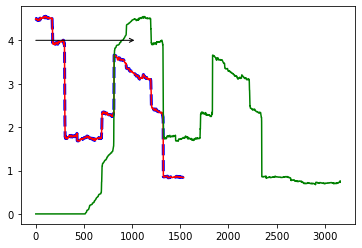

In [64]:
plt.plot(abs(R1), 'b--', lw=3, label='R, method 1')
plt.plot(abs(R2), 'r', label='R, method 2')
plt.plot(abs(R_bar), 'g', label='R, method 3')
plt.annotate(s='', xy=(0,4), xytext=(N,4), arrowprops=dict(arrowstyle='<-', shrinkA=0,shrinkB=0))

<ipython-input-72-994fcac72581>:2: RuntimeWarning: invalid value encountered in true_divide
  M_bar = abs(P_bar)**2/R_bar**2
<ipython-input-72-994fcac72581>:7: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s='', xy=(sto,1), xytext=(sto+2*ofdm.L,1), arrowprops=dict(arrowstyle='<-', shrinkA=0,shrinkB=0));


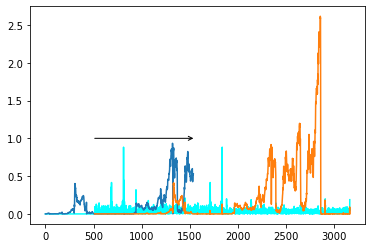

In [72]:
M = abs(P1)**2/R1**2
M_bar = abs(P_bar)**2/R_bar**2

plt.plot(abs(channel_op), label='$r[n]$', color='cyan')
plt.plot(M*100, label='$M(d)$')
plt.plot(M_bar*100, label='$\\bar{M}(d)$')
plt.annotate(s='', xy=(sto,1), xytext=(sto+2*ofdm.L,1), arrowprops=dict(arrowstyle='<-', shrinkA=0,shrinkB=0));

SYNC

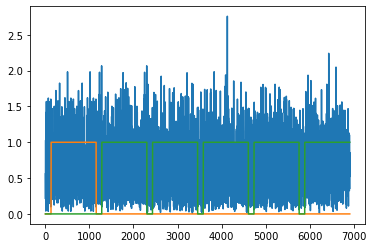

In [73]:
def createFrame_withSyncInfo(ofdm):
    qam_preamble = np.sqrt(2)*random_qam(ofdm)
    qam_preamble[::2] = 0
    preamble = ofdm_modulate(ofdm, qam_preamble)

    payload = np.hstack([ofdm_modulate(ofdm, random_qam(ofdm)) for _ in range(ofdm.ofdmSymbolsPerFrame)])
    
    frame = np.hstack([preamble, payload])
    preamble_valid = np.zeros(len(frame))
    payload_valid = np.zeros(len(frame))
    preamble_valid[ofdm.CP:ofdm.CP+ofdm.K] = 1
    for f in range(ofdm.ofdmSymbolsPerFrame):
        payload_valid[(ofdm.CP+ofdm.K)*(f+1) + ofdm.CP + np.arange(ofdm.K)] = 1
    
    return frame, preamble_valid, payload_valid
frame, preamble_valid, payload_valid = createFrame_withSyncInfo(ofdm)
plt.plot(abs(frame), label='Signal');
plt.plot(preamble_valid, label='Preamble valid')
plt.plot(payload_valid, label='Payload valid')

In [74]:
delays = [1000, 1500, 2000]
tx_signal = []
preamble_valid = []
payload_valid = []
for d in delays:
    Z = np.zeros(d)
    frame, pream_valid, pay_valid = createFrame_withSyncInfo(ofdm)
    tx_signal.extend([frame, Z]); preamble_valid.extend([pream_valid, Z]); payload_valid.extend([pay_valid, Z])
tx_signal = np.hstack(tx_signal); preamble_valid = np.hstack(preamble_valid); payload_valid = np.hstack(payload_valid)

rx_signal = addNoise(addSTO(tx_signal, sto), 0.5)
preamble_valid = addSTO(preamble_valid, sto)
payload_valid = addSTO(payload_valid, sto)
plt.plot(abs(rx_signal), color='cyan', label='RX signal');
plt.plot(preamble_valid, label='Preamble valid')
plt.plot(payload_valid, label='Payload valid')

NameError: name 'addNoise' is not defined